# HW10 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

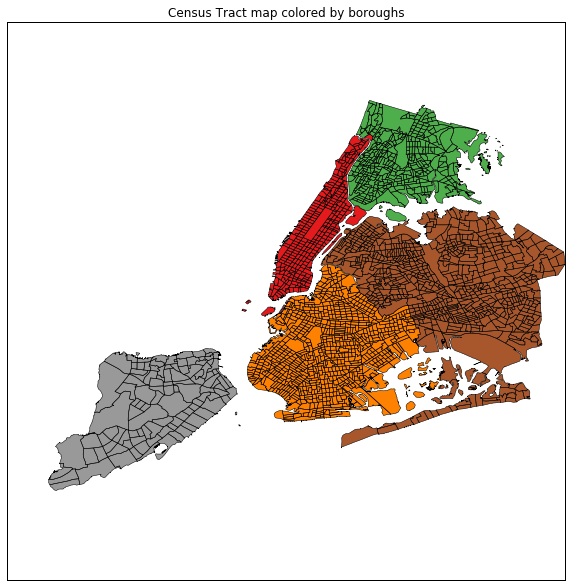

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


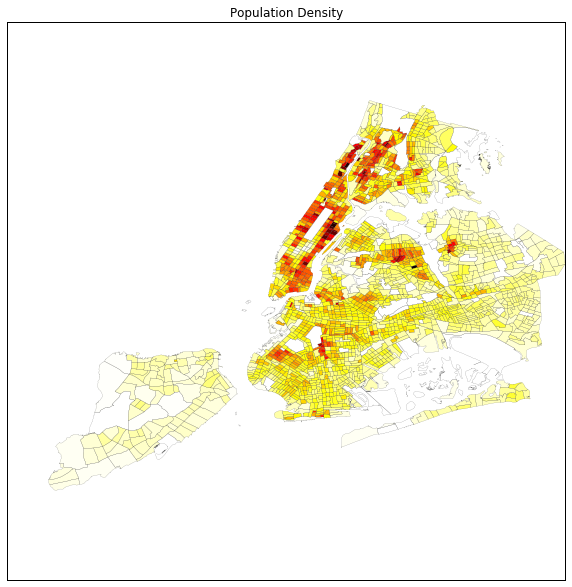

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

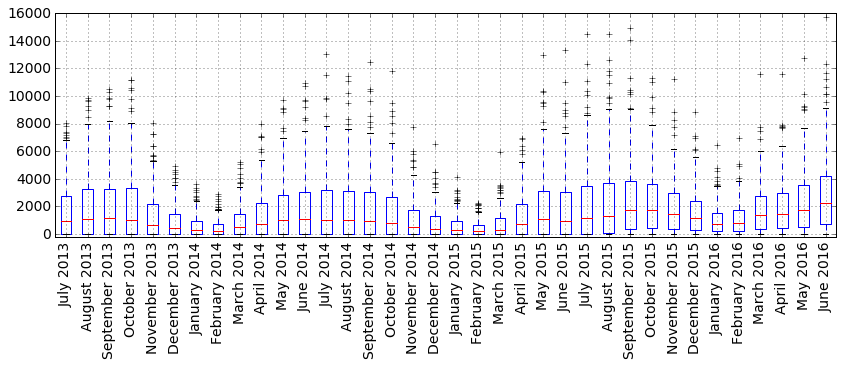

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


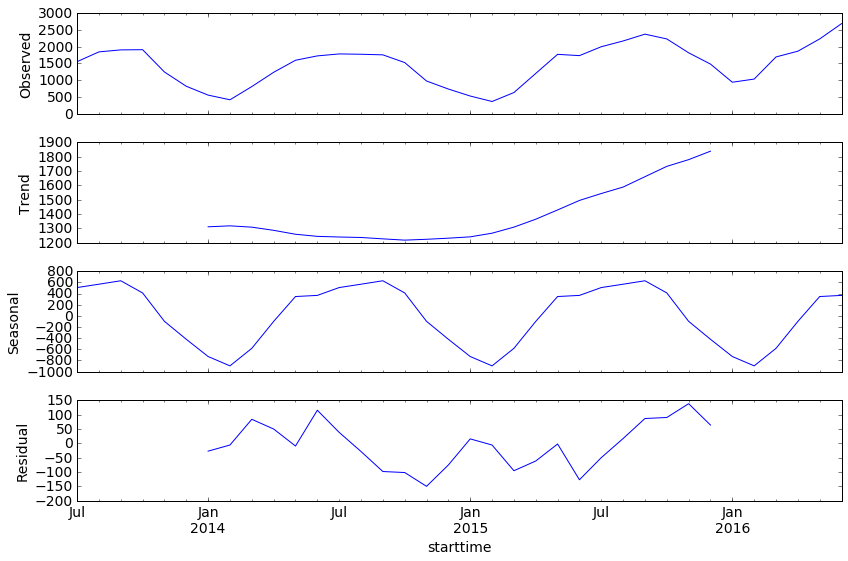

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [13]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [14]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [15]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [16]:
#summer: from May to Sep; winter: from Nov to Mar
df_summer = df_bike_monthly[(df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month >= 5)]
df_winter = df_bike_monthly[(df_bike_monthly.index.month <= 3) | (df_bike_monthly.index.month >= 11)]

In [20]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['summerAve']=df_summer.sum()
station_id['winterAve']=df_winter.sum()
station_id['MonthlyAve']=df_bike_monthly.sum()

In [21]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,summerAve,winterAve,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,37184,18741,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,59241,23799,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,147418,74114,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,55867,27616,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,101767,45843,184044


### Add the monthly average rides to the CT shapefile 

In [22]:
temp_w=station_id[['winterAve']]
temp_w['station_id']=station_id.index
temp_w.index=station_id['BoroCT2010']
ct_shape_winterAve=ct_shape.join(temp_w)
ct_shape_winterAve.fillna(0,inplace=True)

temp_s=station_id[['summerAve']]
temp_s['station_id']=station_id.index
temp_s.index=station_id['BoroCT2010']
ct_shape_summerAve=ct_shape.join(temp_s)
ct_shape_summerAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


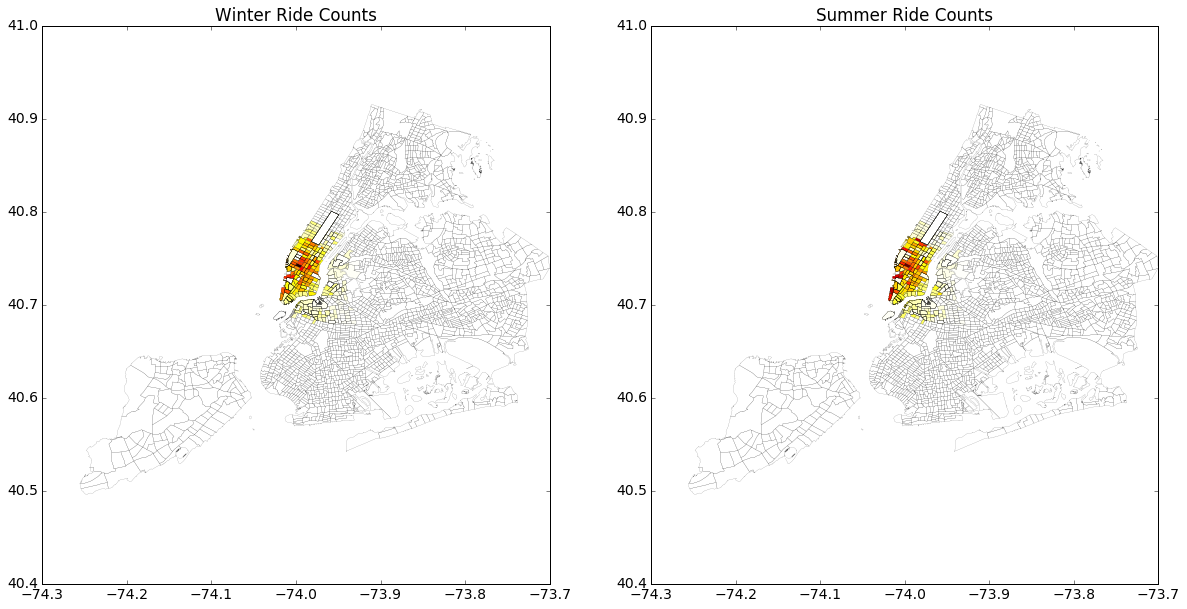

In [25]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ct_shape_winterAve.plot(column='winterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Winter Ride Counts")
ax2 = plt.subplot(122)
ct_shape_summerAve.plot(column='summerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Summer Ride Counts")

### Removing the CTs that are out of zoom boundries

In [26]:
ct_shape_winterAve_Zoom=(ct_shape_winterAve[ct_shape_winterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [27]:
ct_shape_summerAve_Zoom=(ct_shape_summerAve[ct_shape_summerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [29]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs in winter:", len(temp_w.winterAve)
print "Number of zoomed CTs in summer:", len(temp_s.summerAve)

 Total number of CTs: 2166
Number of zoomed CTs in winter: 543
Number of zoomed CTs in summer: 543


### Map the monthly rides 

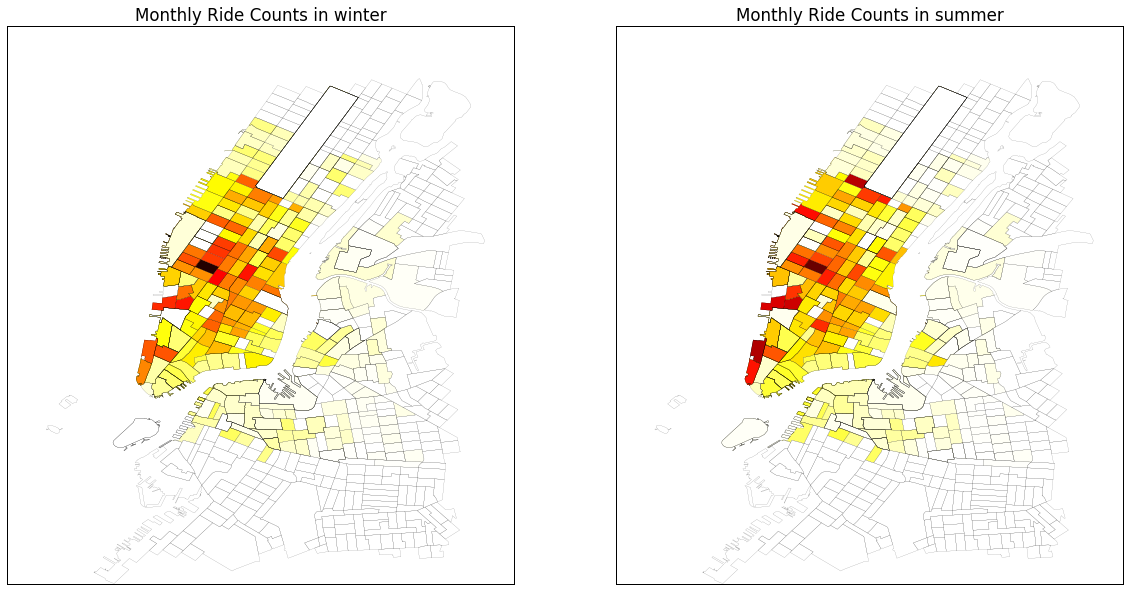

In [31]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ct_shape_winterAve_Zoom.plot(column='winterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Monthly Ride Counts in winter")
ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_summerAve_Zoom.plot(column='summerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Monthly Ride Counts in summer")

### Export Shapefile CTs in the CitiBike Zone

In [42]:
path_w='Data/Output/ct_shape_winterAve_Zoom.shp'
ct_shape_winterAve_Zoom.to_file(path_w)
path_s='Data/Output//ct_shape_summerAve_Zoom.shp'
ct_shape_summerAve_Zoom.to_file(path_s)

## Exploratory Geospatial Analysis

In [37]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [43]:
qW_CT=ps.queen_from_shapefile(path_w)

('Island id: ', [0])


In [44]:
qW_CT=ps.queen_from_shapefile(path_s)

('Island id: ', [0])


#### Neighbors of index10

In [45]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [46]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [47]:
Wmatrix, ids = qW_CT.full()

In [48]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [49]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [50]:
winterRide=ct_shape_winterAve_Zoom.winterAve
winterRideLag=ps.lag_spatial(qW_CT, winterRide)

summerRide=ct_shape_summerAve_Zoom.summerAve
summerRideLag=ps.lag_spatial(qW_CT, summerRide)

#### Create Quantiles for maping

In [51]:
winterRideLagQ10 = ps.Quantiles(winterRideLag, k=10)
winterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    73.857                 2
   73.857 < x[i] <=  1236.500                78
 1236.500 < x[i] <=  3004.263                80
 3004.263 < x[i] <=  4784.657                79
 4784.657 < x[i] <=  7015.056                80
 7015.056 < x[i] <= 15679.919                79
15679.919 < x[i] <= 21478.391                80
21478.391 < x[i] <= 25755.115                79
25755.115 < x[i] <= 41728.643                80

In [52]:
summerRideLagQ10 = ps.Quantiles(summerRideLag, k=10)
summerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   118.714                21
  118.714 < x[i] <=  2001.200                78
 2001.200 < x[i] <=  4570.222                80
 4570.222 < x[i] <=  9678.596                79
 9678.596 < x[i] <= 14583.100                80
14583.100 < x[i] <= 31786.641                79
31786.641 < x[i] <= 45963.500                80
45963.500 < x[i] <= 53341.644                79
53341.644 < x[i] <= 81357.357                80

#### Map the monthly rides lag

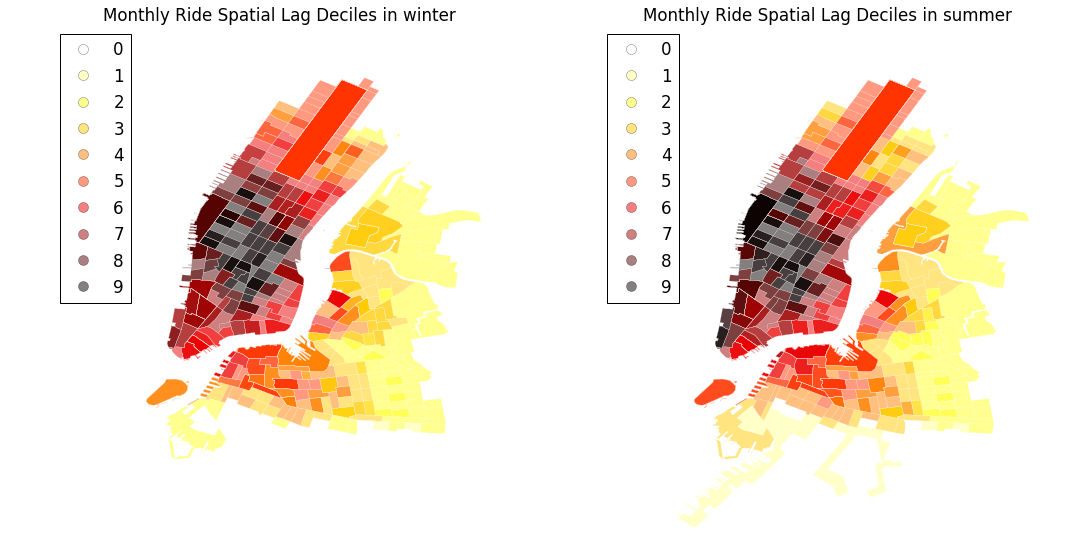

In [54]:
f, ax = plt.subplots(figsize=(18, 9))
ax1 = plt.subplot(121)
ct_shape_winterAve_Zoom.assign(cl=winterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles in winter")

ax2= plt.subplot(122)
ct_shape_summerAve_Zoom.assign(cl=summerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles in summer")

## Global  Spatial Autocorrelation

In [56]:
b,a = np.polyfit(winterRide, winterRideLag, 1)
print "in winter,slope =" ,b , "intercept=" ,a 

in winter,slope = 0.662161674036 intercept= 3266.88834533


In [58]:
b,a = np.polyfit(summerRide, summerRideLag, 1)
print "in summer,slope =" ,b , "intercept=" ,a 

in summer,slope = 0.643249726194 intercept= 7089.94094213


### Moran Scatterplot

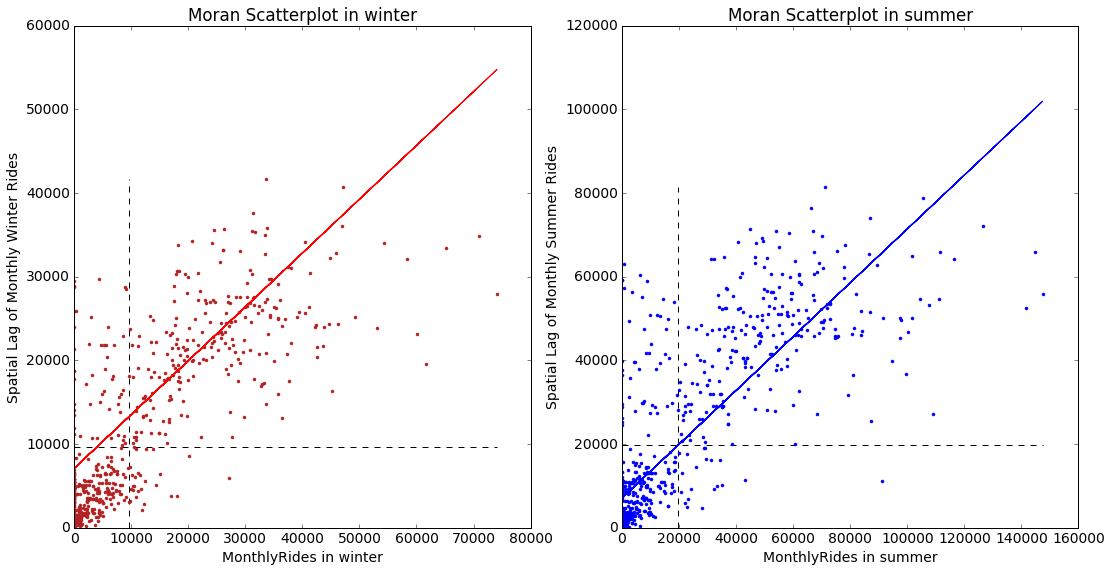

In [64]:
f, ax = plt.subplots(1, figsize=(18, 9))

ax1 = plt.subplot(121)
ax1.plot(winterRide, winterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(winterRide.mean(), winterRideLag.min(), winterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(winterRideLag.mean(), winterRide.min(), winterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(winterRide, a + b*winterRide, 'r')
plt.title('Moran Scatterplot in winter')
plt.ylabel('Spatial Lag of Monthly Winter Rides')
plt.xlabel('MonthlyRides in winter')

ax2 = plt.subplot(122)
ax2.plot(summerRide, summerRideLag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
ax2.vlines(summerRide.mean(), summerRideLag.min(), summerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax2.hlines(summerRideLag.mean(), summerRide.min(), summerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax2.plot(summerRide, a + b*summerRide, 'blue')
plt.title('Moran Scatterplot in summer')
plt.ylabel('Spatial Lag of Monthly Summer Rides')
plt.xlabel('MonthlyRides in summer')

### Moran's I

In [65]:
I_winterRide = ps.Moran(winterRide, qW_CT)
I_summerRide = ps.Moran(summerRide, qW_CT)

In [66]:
print "winter", I_winterRide.I, I_winterRide.p_sim
print "summer", I_summerRide.I, I_summerRide.p_sim

winter 0.662314816386 0.001
summer 0.643413569648 0.001


Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [68]:
print "winter:"
print I_winterRide.sim[0:10]
print "summer:"
print I_summerRide.sim[0:10]

winter:
[-0.0123037  -0.01512766  0.0144679  -0.00536301 -0.03622028 -0.01078622
 -0.00760985 -0.01655825 -0.013065    0.00751044]
summer:
[ 0.02557362 -0.0086569   0.00690345  0.01391212  0.00243181  0.01368596
 -0.01934318  0.01614307  0.01174599 -0.00185863]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [69]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

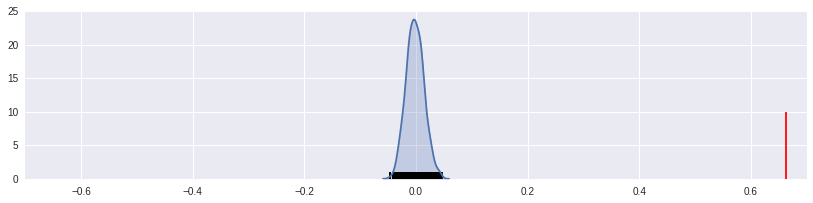

In [70]:
sns.kdeplot(I_winterRide.sim, shade=True)
plt.vlines(I_winterRide.sim, 0, 1)
plt.vlines(I_winterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

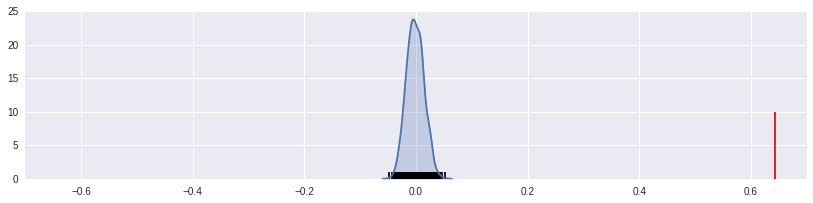

In [71]:
sns.kdeplot(I_summerRide.sim, shade=True)
plt.vlines(I_summerRide.sim, 0, 1)
plt.vlines(I_summerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

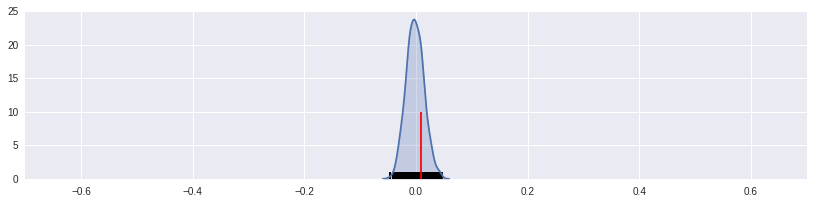

In [72]:
sns.kdeplot(I_winterRide.sim, shade=True)
plt.vlines(I_winterRide.sim, 0, 1)
plt.vlines(I_winterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

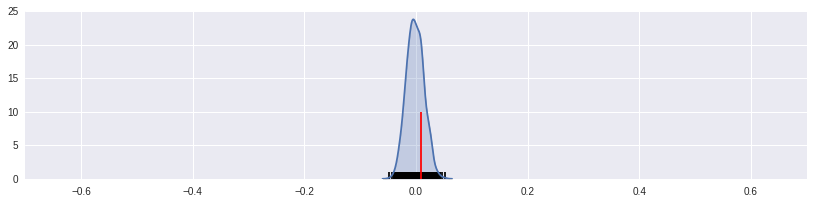

In [73]:
sns.kdeplot(I_summerRide.sim, shade=True)
plt.vlines(I_summerRide.sim, 0, 1)
plt.vlines(I_summerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [74]:
LMo_winterRide = ps.Moran_Local(winterRide, qW_CT,permutations=999)
LMo_summerRide = ps.Moran_Local(summerRide, qW_CT,permutations=999)

In [77]:
print "winter:"
print LMo_winterRide.Is[0:5], LMo_winterRide.p_sim[0:5]
print "summer:"
print LMo_summerRide.Is[0:5], LMo_summerRide.p_sim[0:5]

winter:
[ -0.00000000e+00  -2.94807567e-01  -1.34956975e-04  -1.46810031e-03
  -6.07719880e-02] [ 0.001  0.164  0.469  0.499  0.427]
summer:
[-0.         -0.23886262  0.01265189  0.00397506  0.02321185] [ 0.001  0.189  0.368  0.374  0.372]


### LISA (Local Indicators of Spatial Autocorrelation)

In [78]:
sigs_w = winterRide[LMo_winterRide.p_sim <= .001]
W_sigs_w = winterRideLag[LMo_winterRide.p_sim <= .001]
insigs_w = winterRide[LMo_winterRide.p_sim > .001]
W_insigs_w = winterRideLag[LMo_winterRide.p_sim > .001]

In [79]:
sigs_s = summerRide[LMo_summerRide.p_sim <= .001]
W_sigs_s = summerRideLag[LMo_summerRide.p_sim <= .001]
insigs_s = summerRide[LMo_summerRide.p_sim > .001]
W_insigs_s = summerRideLag[LMo_summerRide.p_sim > .001]

### Plot Signficant LISA

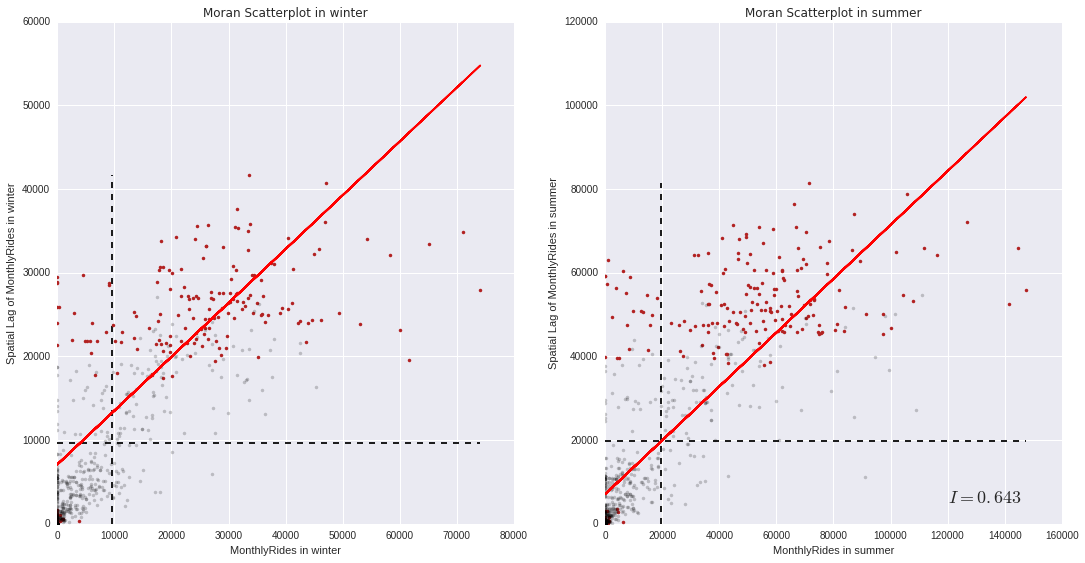

In [80]:
f, ax = plt.subplots(figsize=(18, 9))
ax1 = plt.subplot(121)
plt.plot(sigs_w, W_sigs_w, '.', color='firebrick')
plt.plot(insigs_w, W_insigs_w, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_winterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(winterRide.mean(), winterRideLag.min(), winterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winterRideLag.mean(), winterRide.min(), winterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winterRide, a + b*winterRide, 'r')
plt.title('Moran Scatterplot in winter')
plt.ylabel('Spatial Lag of MonthlyRides in winter')
plt.xlabel('MonthlyRides in winter')

ax2 = plt.subplot(122)
plt.plot(sigs_s, W_sigs_s, '.', color='firebrick')
plt.plot(insigs_s, W_insigs_s, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_summerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(summerRide.mean(), summerRideLag.min(), summerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summerRideLag.mean(), summerRide.min(), summerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summerRide, a + b*summerRide, 'r')
plt.title('Moran Scatterplot in summer')
plt.ylabel('Spatial Lag of MonthlyRides in summer')
plt.xlabel('MonthlyRides in summer')

From the plots above and moran's I, in the winter the autocorrelation is larger than in the summer. 

### Hot and Cold spots 

In [83]:
sig_w = LMo_winterRide.p_sim < 0.01
hotspots_w = LMo_winterRide.q==1 * sig_w
coldspots_w = LMo_winterRide.q==3 * sig_w
print "Number of Hotspots in winter:", hotspots_w.sum()
print "Number of Coldspots in winter:", coldspots_w.sum()

 Number of Hotspots in winter: 197
Number of Coldspots in winter: 214


In [85]:
sig_s = LMo_summerRide.p_sim < 0.01
hotspots_s = LMo_summerRide.q==1 * sig_s
coldspots_s = LMo_summerRide.q==3 * sig_s
print "Number of Hotspots in summer:", hotspots_s.sum()
print "Number of Coldspots in summer:", coldspots_s.sum()

Number of Hotspots in summer: 187
Number of Coldspots in summer: 237


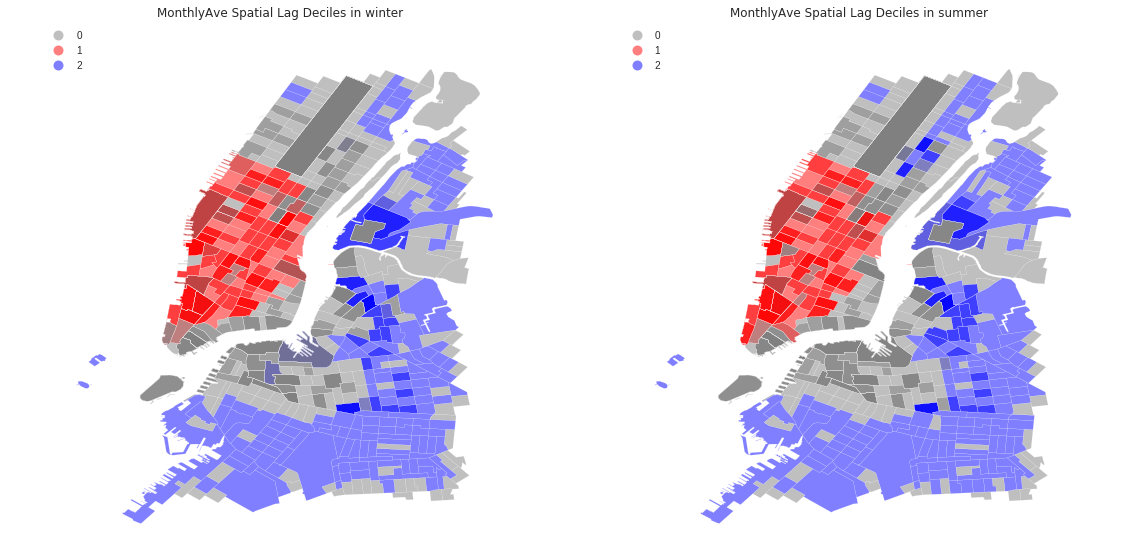

In [87]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w*1 + coldspots_w*2
hotcold_s = hotspots_s*1 + coldspots_s*2

f, ax = plt.subplots(figsize=(19, 9))
ax1 = plt.subplot(121)
ct_shape_winterAve_Zoom.assign(cl=hotcold_w).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles in winter")

ax2 = plt.subplot(122)
ct_shape_winterAve_Zoom.assign(cl=hotcold_s).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles in summer")